# Plot Fisher information

Johann Brehmer, Kyle Cranmer, Felix Kling, Duccio Pappadopulo, Josh Ruderman 2018

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
% matplotlib inline
import logging
import os

import madminer.core
from madminer.plotting import plot_fisher_information_contours_2d

logging.basicConfig(format='%(asctime)s  %(message)s', datefmt='%H:%M')

In [2]:
base_dir = '/Users/johannbrehmer/work/projects/madminer/diboson_mining/'
mg_dir = '/Users/johannbrehmer/work/projects/madminer/MG5_aMC_v2_6_2/'

In [3]:
sample_dir = base_dir + 'data/samples/wgamma/'
card_dir = base_dir + 'cards/wgamma/'
ufo_model_dir = card_dir + 'SMWgamma_UFO'
run_card_dir = card_dir + 'run_cards/'
mg_process_dir = base_dir + 'data/mg_processes/wgamma/'
log_dir = base_dir + 'logs/wgamma/'
temp_dir = base_dir + 'data/temp'
delphes_dir = mg_dir + 'Delphes'
model_dir = base_dir + 'data/models/wgamma/'
result_dir = base_dir + 'data/results/wgamma/'

## Load Fisher information results

In [4]:
info_xsec = np.load(result_dir + 'information_xsec.npy')

In [5]:
infos  = [info_xsec]
covs   = [None]
labels = ['xsec']
colors = ['0.5']
lss    = ['-']

In [6]:
histo_filenames = ['met', 'ptl', 'pta', 'deltaphi_lv', 'deltaphi_la']
histo_labels    = ['MET', r'$p_{T,\ell}$', r'$p_{T,\gamma}$', r'$\Delta\phi$', r'$\Delta\phi_{\ell\gamma}$']
histo_colors    = ['dodgerblue', 'deepskyblue', 'steelblue', 'mediumblue', 'cornflowerblue']
histo_lss       = ['--', '-.', ':']*2

for hfilename, hlabel, hcolor, hls in zip(histo_filenames, histo_labels, histo_colors, histo_lss):
    infos.append(
        np.load(result_dir + 'information_histo_{}.npy'.format(hfilename))
    )
    covs.append(None)
    labels.append(hlabel)
    colors.append(hcolor)
    lss.append(hls)

In [7]:
ml_filenames = ['full', 'deltaphi', 'met', 'dummy']
ml_labels    = ['full', r'$\Delta\phi$', 'MET', 'dummy']
ml_colors    = ['#CC002E', 'orangered', 'r', 'firebrick', 'lightcoral', 'lightsalmon', 'chocolate']
ml_lss       = ['-']*2 + ['--', '-.', ':']*2

for hfilename, hlabel, hcolor, hls in zip(ml_filenames, ml_labels, ml_colors, ml_lss):
    infos.append(
        np.load(result_dir + 'information_mean_{}.npy'.format(hfilename))
    )
    covs.append(
        np.load(result_dir + 'information_covariance_{}.npy'.format(hfilename))
    )
    labels.append(hlabel)
    colors.append(hcolor)
    lss.append(hls)

## Plot

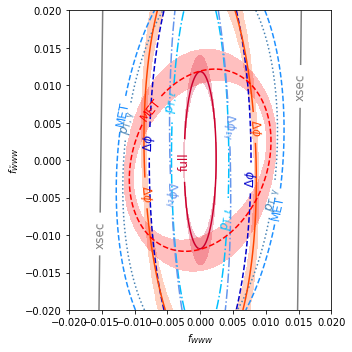

In [9]:
xmax = 0.02

fig = plot_fisher_information_contours_2d(
    fisher_information_matrices=infos,
    fisher_information_covariances=covs,
    contour_distance=1.,
    xrange=(-xmax,xmax),
    yrange=(-xmax,xmax),
    xlabel=r'$f_{WWW}$',
    ylabel=r'$f_{\tilde{W}WW}$',
    linestyles=lss,
    colors=colors,
    resolution=600,
    inline_labels=labels
)

plt.savefig('wgamma_information.pdf')
